## Extraction ## 
- This section is to remove needed inforamtion from the PDF(s)

In [2]:
#import packages 
import io #for input and output operations
import requests #to get() the PDFs or url
from PyPDF2 import PdfReader #package for reading info from the PDFs
import pdfplumber #package for reading info from the PDFs
import re #regular expressions allows a user to search for strings
from itertools import chain # used to merge ranges
import pandas as pd
import numpy as np
from sklearn import preprocessing #for text cleaning
import matplotlib.pyplot as plt #for plotting
from sklearn.feature_extraction.text import TfidfVectorizer #for text representation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#model testing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [15]:
url = 'https://www.whitehouse.gov/wp-content/uploads/2022/05/BUILDING-A-BETTER-AMERICA-V2.pdf' #website containing PDFs
r = requests.get(url) #retrieve url
f = io.BytesIO(r.content) #manipulate binary data in-memory; this functions the same as with open(file, 'rb') but serves as a temporary buffer

In [16]:
#this box uses pdfplumber - please remeber this code is specific to using th pdfplumber package and to this document https://www.whitehouse.gov/wp-content/uploads/2022/05/BUILDING-A-BETTER-AMERICA-V2.pdf
def extractPDF(f, extractPages, keywords): #function to extract keywords and trailing information  from needed pages
    with pdfplumber.open(f) as pdf:
        pdfData = [] #initliaze storage for entire pdf data 
        
        for i in extractPages: #python is exclusive for ranges so what ever your end is add 1, this range could be changed to user input for ranges i = actual page number + 1 so i=15 is actually page 14 in the document
            #print(i)
            currentPage = pdf.pages[i] #current page i
            pageContent = currentPage.extract_text() #extract text from current page i

            name = pageContent.split('\n')[1]
            #print(name) #capture the name of the program by splitting by newline (this only works for pdfplumber and this document)
            pageData = {'program': name} #initialize data dictionary
        
            for index, key in enumerate(keywords): 

                if index < (len(keywords) - 1): #condition to not go passed the bounds of the array
                #print(key2)
                    nextKey = keywords[index+1] #access the next keyword
                    pattern = '(?<='+key+')(.*)(?='+nextKey+')' #cannot use $ EOF because it will bypass the bounding keyword and give the remaining page text every time -- (.*) is the same as writing [\s\w\d\W]+
                    #print(pattern)
                    values = re.search(pattern, pageContent, re.IGNORECASE | re.DOTALL)
                    keyValue = values.group().strip() #returns the subtring that matches the regular expression and removes leading and trailing whitespace characters
                    #print(keyValue)
                    pageData[key] = keyValue #add new value pair to dictionary

                else:
                    #print(pattern)
                    eofPattern = '(?<='+keywords[-1]+')(.*)(?=$|\\n)' #this does not handle if the end of page keyword is not put in! would have to use all keywords on page for this solution to work #should you exclude "BUILDING A BETTER AMERICA | GUIDEBOOK MAY 2022" here
                    values = re.search(eofPattern, pageContent, re.IGNORECASE | re.DOTALL)
                    keyValue = values.group().strip() #returns the subtring that matches the regular expression and removes leading and trailing whitespace characters
                    #print(keyValue)
                    pageData[key] = keyValue #add new value pair to dictionary

            #print(pageData)
            pdfData.append(pageData) #append page data to previous pdf data
            #print(pdfData)
    return pdfData



In [17]:
extractPages = chain(range(15,56), range(59,64), range(67,92), range(95,98), range(101,116), range(119,137), range(140,150), range(156,178), range(180,206), range(208,225), range(230,265), range(271,340), range(374,378), range(380,383), range(388,399), range(403, 413), range(414, 428), range(429, 431), range(432,439), range(440,441), range(443,447)) #input multiple ranges because not all pages are relevant (leaving page 177 & 178, 205 & 206, 377 & 378 out for now because they span multiple pages)
keywords = ['Federal Agency:', 'Bureau or Account:', 'Funding amount:', 'Period of availability:', 'Funding mechanism:', 'New program:', 'Recipients:', 'Description:', 'Eligible uses:', 'Federal cost share requirement:', 'Statutory location:'] #list of keywords from PDF
            
extracted = extractPDF(f, extractPages, keywords)

## Clean-Up ## 
- This section is to clean up the extracted data

In [18]:
pdfDT = pd.DataFrame(extracted)
pdfDT.rename(columns={'Federal Agency:':'agency', 'Bureau or Account:':'bureau', 'Funding amount:':'funding_amt', 'Funding mechanism:':'funding_type', 'Recipients:':'eligibility', 'Description:':'description', 'Eligible uses:':'eligible_uses'}, inplace=True)
pdfDT

,program,agency,bureau,funding_amt,Period of availability:,funding_type,New program:,eligibility,description,eligible_uses,Federal cost share requirement:,Statutory location:
0,National Highway Performance Program,Department of Transportation,Federal Highway Administration,"$148,000,000,000",4 year,Formula Grant,No. Existing Program with Changed Eligibilities,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,"Highway and bridge projects, generally on the ...","Typically, 80 percent Federal / 20 percent non...",11101; 11105\nBUILDING A BETTER AMERICA | GUID...
1,Surface Transportation Block Grant Program,Department of Transportation,Federal Highway Administration,"$72,000,000,000",4 year,Formula Grant,No. Existing Program with Changed Eligibilities,States (including District of Columbia),The Surface Transportation Block Grant Program...,The Surface Transportation Block Grant Program...,"Typically, 80 percent Federal / 20 percent non...",11101; 11109\nBUILDING A BETTER AMERICA | GUID...
2,Bridge Formula Program,Department of Transportation,Federal Highway Administration,"$26,675,000,000",4 year,Formula Grant,Yes,States (including District of Columbia and Pue...,The Bridge Formula Program will provide funds ...,"Replace, rehabilitate, preserve, protect, and ...","Typically, 80 percent Federal / 20 percent non...","Division J, Title VIII\nBUILDING A BETTER AMER..."
3,Tribal Transportation Facility Bridges (Bridge...,Department of Transportation,Federal Highway Administration,"$825,000,000",4 year,Distributed through the Tribal Transportation ...,No,Tribes,The Bridge Formula Program sets aside 3 percen...,"Funds can be used to plan, design, engineer, o...",100 percent Federal share,"Division J, Title VIII\nBUILDING A BETTER AMER..."
4,Congestion Mitigation and Air Quality Improvem...,Department of Transportation,Federal Highway Administration,"$13,200,000,000",4 year,Formula Grant,No. Existing Program with Changed Eligibilities,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,Transportation projects that reduce congestion...,"Typically, 80 percent Federal / 20 percent non...",11101; 11115\nBUILDING A BETTER AMERICA | GUID...
...,...,...,...,...,...,...,...,...,...,...,...,...
337,Gulf Hypoxia,Environmental Protection Agency,Environmental Protection Agency,"$60,000,000",Available until expended,Grant,Yes,12 State Members of Gulf Hypoxia Task Force (A...,The Gulf of Mexico Hypoxia Task Force includes...,,No non-Federal cost share required,"Division J, Title VI\nNote: This program was c..."
338,Solid Waste Infrastructure for Recycling Infra...,Environmental Protection Agency,Environmental Protection Agency,"$275,000,000",Available until expended,Cooperative Agreements and/or Grants,Yes,"States (including the District of Columbia, a ...",Communities across the country are burdened by...,Provide grants to implement a strategy to impr...,No non-Federal cost share required,70402\nBUILDING A BETTER AMERICA | GUIDEBOOK M...
339,"Reduce, Reuse, Recycling Education and Outreac...",Environmental Protection Agency,Environmental Protection Agency,"$75,000,000",Available until expended,Cooperative Agreements and/or Grants,Yes,"States, a Unit of Local Government, Tribal Gov...",Communities across the country are burdened by...,To award grants focused on improving material ...,No non-Federal cost share required,70402\nBUILDING A BETTER AMERICA | GUIDEBOOK M...
340,Battery Labeling Guidelines,Environmental Protection Agency,Environmental Protection Agency,"$15,000,000","fiscal year 2022, to remain available until Se...",Contracts,Yes,N/A,This investment will promote the safe handling...,Establishes a program to promote battery recyc...,No non-Federal cost share required,"Division J, Title VI\nBUILDING A BETTER AMERIC..."


In [19]:
pdfDT.drop(columns=['Period of availability:','New program:', 'Federal cost share requirement:', 'Statutory location:'], axis=1, inplace=True) #drop unnecessary info

In [20]:

#put columns in correct order (may not matter)
dbColumns = {'category':0, 'category_label':1, 'agencyId':2, 'eligibilityId':3, 'funding_amt_notes':8, 'funding_bill':10, 'next_milestone':14 ,'application':15 , 'link':16, 'pollution':17, 'technical':18}
for column, position in dbColumns.items(): 
    pdfDT.insert(position, column, np.nan)
pdfDT['link'] = url
pdfDT

,category,category_label,agencyId,eligibilityId,program,agency,bureau,funding_amt,funding_amt_notes,funding_type,funding_bill,eligibility,description,eligible_uses,next_milestone,application,link,pollution,technical
0,NaN,NaN,NaN,NaN,National Highway Performance Program,Department of Transportation,Federal Highway Administration,"$148,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,"Highway and bridge projects, generally on the ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
1,NaN,NaN,NaN,NaN,Surface Transportation Block Grant Program,Department of Transportation,Federal Highway Administration,"$72,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Surface Transportation Block Grant Program...,The Surface Transportation Block Grant Program...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
2,NaN,NaN,NaN,NaN,Bridge Formula Program,Department of Transportation,Federal Highway Administration,"$26,675,000,000",NaN,Formula Grant,NaN,States (including District of Columbia and Pue...,The Bridge Formula Program will provide funds ...,"Replace, rehabilitate, preserve, protect, and ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
3,NaN,NaN,NaN,NaN,Tribal Transportation Facility Bridges (Bridge...,Department of Transportation,Federal Highway Administration,"$825,000,000",NaN,Distributed through the Tribal Transportation ...,NaN,Tribes,The Bridge Formula Program sets aside 3 percen...,"Funds can be used to plan, design, engineer, o...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
4,NaN,NaN,NaN,NaN,Congestion Mitigation and Air Quality Improvem...,Department of Transportation,Federal Highway Administration,"$13,200,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,Transportation projects that reduce congestion...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,NaN,NaN,NaN,Gulf Hypoxia,Environmental Protection Agency,Environmental Protection Agency,"$60,000,000",NaN,Grant,NaN,12 State Members of Gulf Hypoxia Task Force (A...,The Gulf of Mexico Hypoxia Task Force includes...,,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
338,NaN,NaN,NaN,NaN,Solid Waste Infrastructure for Recycling Infra...,Environmental Protection Agency,Environmental Protection Agency,"$275,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States (including the District of Columbia, a ...",Communities across the country are burdened by...,Provide grants to implement a strategy to impr...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
339,NaN,NaN,NaN,NaN,"Reduce, Reuse, Recycling Education and Outreac...",Environmental Protection Agency,Environmental Protection Agency,"$75,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States, a Unit of Local Government, Tribal Gov...",Communities across the country are burdened by...,To award grants focused on improving material ...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
340,NaN,NaN,NaN,NaN,Battery Labeling Guidelines,Environmental Protection Agency,Environmental Protection Agency,"$15,000,000",NaN,Contracts,NaN,N/A,This investment will promote the safe handling...,Establishes a program to promote battery recyc...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN


In [21]:
pdfDT = pdfDT.replace('\n',' ', regex=True) #just in case there are new line breaks in the decriptions but may need to clearn further to join disjointed words
pdfDT

,category,category_label,agencyId,eligibilityId,program,agency,bureau,funding_amt,funding_amt_notes,funding_type,funding_bill,eligibility,description,eligible_uses,next_milestone,application,link,pollution,technical
0,NaN,NaN,NaN,NaN,National Highway Performance Program,Department of Transportation,Federal Highway Administration,"$148,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,"Highway and bridge projects, generally on the ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
1,NaN,NaN,NaN,NaN,Surface Transportation Block Grant Program,Department of Transportation,Federal Highway Administration,"$72,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Surface Transportation Block Grant Program...,The Surface Transportation Block Grant Program...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
2,NaN,NaN,NaN,NaN,Bridge Formula Program,Department of Transportation,Federal Highway Administration,"$26,675,000,000",NaN,Formula Grant,NaN,States (including District of Columbia and Pue...,The Bridge Formula Program will provide funds ...,"Replace, rehabilitate, preserve, protect, and ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
3,NaN,NaN,NaN,NaN,Tribal Transportation Facility Bridges (Bridge...,Department of Transportation,Federal Highway Administration,"$825,000,000",NaN,Distributed through the Tribal Transportation ...,NaN,Tribes,The Bridge Formula Program sets aside 3 percen...,"Funds can be used to plan, design, engineer, o...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
4,NaN,NaN,NaN,NaN,Congestion Mitigation and Air Quality Improvem...,Department of Transportation,Federal Highway Administration,"$13,200,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,Transportation projects that reduce congestion...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,NaN,NaN,NaN,Gulf Hypoxia,Environmental Protection Agency,Environmental Protection Agency,"$60,000,000",NaN,Grant,NaN,12 State Members of Gulf Hypoxia Task Force (A...,The Gulf of Mexico Hypoxia Task Force includes...,,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
338,NaN,NaN,NaN,NaN,Solid Waste Infrastructure for Recycling Infra...,Environmental Protection Agency,Environmental Protection Agency,"$275,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States (including the District of Columbia, a ...",Communities across the country are burdened by...,Provide grants to implement a strategy to impr...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
339,NaN,NaN,NaN,NaN,"Reduce, Reuse, Recycling Education and Outreac...",Environmental Protection Agency,Environmental Protection Agency,"$75,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States, a Unit of Local Government, Tribal Gov...",Communities across the country are burdened by...,To award grants focused on improving material ...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
340,NaN,NaN,NaN,NaN,Battery Labeling Guidelines,Environmental Protection Agency,Environmental Protection Agency,"$15,000,000",NaN,Contracts,NaN,N/A,This investment will promote the safe handling...,Establishes a program to promote battery recyc...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN


In [22]:
#agencyId column update!
#-----------------------

pdfDT['agency'].unique() #get unique values
abbr = {'Department of Transportation': 'dot', 'Department of Defense – Army Corps of Engineers' :'dod-ace', 'General Services Administration':'gsa', 'Department of Homeland Security':'dhs', 'Environmental Protection Agency':'epa', 'Department of Energy':'doe',
        'Department of the Interior':'doi', 'Department of Agriculture':'doa', 'Department of Health and Human Services':'dhhs', 'Department of Commerce':'doc', 'Federal Communications Commission':'fcc', 'Denali Commission':'denali', 'Appalachian Regional Commission':'arc',
       'Delta Regional Authority':'dra', 'Northern Border Regional Commission':'nbrc','Southeast Crescent Regional Commission':'scrc'} #create dictionary of agency abbreviates (how to handle subbranch of dod?)

pdfDT['agencyId'] = pdfDT['agency'].map(abbr) #map abbreviations to agency names

pdfDT

,category,category_label,agencyId,eligibilityId,program,agency,bureau,funding_amt,funding_amt_notes,funding_type,funding_bill,eligibility,description,eligible_uses,next_milestone,application,link,pollution,technical
0,NaN,NaN,dot,NaN,National Highway Performance Program,Department of Transportation,Federal Highway Administration,"$148,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,"Highway and bridge projects, generally on the ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
1,NaN,NaN,dot,NaN,Surface Transportation Block Grant Program,Department of Transportation,Federal Highway Administration,"$72,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Surface Transportation Block Grant Program...,The Surface Transportation Block Grant Program...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
2,NaN,NaN,dot,NaN,Bridge Formula Program,Department of Transportation,Federal Highway Administration,"$26,675,000,000",NaN,Formula Grant,NaN,States (including District of Columbia and Pue...,The Bridge Formula Program will provide funds ...,"Replace, rehabilitate, preserve, protect, and ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
3,NaN,NaN,dot,NaN,Tribal Transportation Facility Bridges (Bridge...,Department of Transportation,Federal Highway Administration,"$825,000,000",NaN,Distributed through the Tribal Transportation ...,NaN,Tribes,The Bridge Formula Program sets aside 3 percen...,"Funds can be used to plan, design, engineer, o...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
4,NaN,NaN,dot,NaN,Congestion Mitigation and Air Quality Improvem...,Department of Transportation,Federal Highway Administration,"$13,200,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,Transportation projects that reduce congestion...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,NaN,epa,NaN,Gulf Hypoxia,Environmental Protection Agency,Environmental Protection Agency,"$60,000,000",NaN,Grant,NaN,12 State Members of Gulf Hypoxia Task Force (A...,The Gulf of Mexico Hypoxia Task Force includes...,,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
338,NaN,NaN,epa,NaN,Solid Waste Infrastructure for Recycling Infra...,Environmental Protection Agency,Environmental Protection Agency,"$275,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States (including the District of Columbia, a ...",Communities across the country are burdened by...,Provide grants to implement a strategy to impr...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
339,NaN,NaN,epa,NaN,"Reduce, Reuse, Recycling Education and Outreac...",Environmental Protection Agency,Environmental Protection Agency,"$75,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States, a Unit of Local Government, Tribal Gov...",Communities across the country are burdened by...,To award grants focused on improving material ...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
340,NaN,NaN,epa,NaN,Battery Labeling Guidelines,Environmental Protection Agency,Environmental Protection Agency,"$15,000,000",NaN,Contracts,NaN,N/A,This investment will promote the safe handling...,Establishes a program to promote battery recyc...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN


In [23]:
#eligibilityId column update
#---------------------------
#eligibility ID dictionary 
eligID = {'tribes':'.tribal', 'tribal':'.tribal',
          'states':'.stateGov', 
          'nonprofits':'.ngo', 
          'local':'.localGov','town': '.localGov', 'townships': '.localGov','cities': '.localGov','counties': '.localGov','county': '.localGov',
          'community':'.communitygroup',
          'university':'.ed', 'education':'.ed',
          'agricultural':'.agricultural'} #what's the difference between stategov, localgov, and statescountiescities, how to code .statesCountiesCities and .indiv 
#pdfDT['eligibilityId'] = pdfDT['eligibility'].map(eligID)
eligKeys = list(eligID.keys()) # lists out all the keys of the key value pairs

for index, row in pdfDT.iterrows(): #goes through each row of the dataframe
    pattern = r'\b({})\b'.format('|'.join(map(re.escape, eligKeys)))
    # unique matches
    matches = set(re.findall(pattern, row['eligibility'].lower(), re.IGNORECASE))
    values = {eligID[x] for x in matches}
    pdfDT.loc[index,"eligibilityId"] = ', '.join(values)
    
    #print(IDlist)

#print(', '.join(matches)) #PRINTS IT IN LIST FORM
pdfDT
#pdfDT.to_csv('AJCspreadsheet_replica.csv', index=False)


,category,category_label,agencyId,eligibilityId,program,agency,bureau,funding_amt,funding_amt_notes,funding_type,funding_bill,eligibility,description,eligible_uses,next_milestone,application,link,pollution,technical
0,NaN,NaN,dot,.stateGov,National Highway Performance Program,Department of Transportation,Federal Highway Administration,"$148,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,"Highway and bridge projects, generally on the ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
1,NaN,NaN,dot,.stateGov,Surface Transportation Block Grant Program,Department of Transportation,Federal Highway Administration,"$72,000,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Surface Transportation Block Grant Program...,The Surface Transportation Block Grant Program...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
2,NaN,NaN,dot,.stateGov,Bridge Formula Program,Department of Transportation,Federal Highway Administration,"$26,675,000,000",NaN,Formula Grant,NaN,States (including District of Columbia and Pue...,The Bridge Formula Program will provide funds ...,"Replace, rehabilitate, preserve, protect, and ...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
3,NaN,NaN,dot,.tribal,Tribal Transportation Facility Bridges (Bridge...,Department of Transportation,Federal Highway Administration,"$825,000,000",NaN,Distributed through the Tribal Transportation ...,NaN,Tribes,The Bridge Formula Program sets aside 3 percen...,"Funds can be used to plan, design, engineer, o...",NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
4,NaN,NaN,dot,.stateGov,Congestion Mitigation and Air Quality Improvem...,Department of Transportation,Federal Highway Administration,"$13,200,000,000",NaN,Formula Grant,NaN,States (including District of Columbia),The Bipartisan Infrastructure Law continues th...,Transportation projects that reduce congestion...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,NaN,epa,,Gulf Hypoxia,Environmental Protection Agency,Environmental Protection Agency,"$60,000,000",NaN,Grant,NaN,12 State Members of Gulf Hypoxia Task Force (A...,The Gulf of Mexico Hypoxia Task Force includes...,,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
338,NaN,NaN,epa,".stateGov, .tribal",Solid Waste Infrastructure for Recycling Infra...,Environmental Protection Agency,Environmental Protection Agency,"$275,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States (including the District of Columbia, a ...",Communities across the country are burdened by...,Provide grants to implement a strategy to impr...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
339,NaN,NaN,epa,".stateGov, .localGov, .tribal","Reduce, Reuse, Recycling Education and Outreac...",Environmental Protection Agency,Environmental Protection Agency,"$75,000,000",NaN,Cooperative Agreements and/or Grants,NaN,"States, a Unit of Local Government, Tribal Gov...",Communities across the country are burdened by...,To award grants focused on improving material ...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN
340,NaN,NaN,epa,,Battery Labeling Guidelines,Environmental Protection Agency,Environmental Protection Agency,"$15,000,000",NaN,Contracts,NaN,N/A,This investment will promote the safe handling...,Establishes a program to promote battery recyc...,NaN,NaN,https://www.whitehouse.gov/wp-content/uploads/...,NaN,NaN


#### NLP Multiclass Text Classificaiton ####

In [24]:
#NLP Topic Classfication - automatically analyze text and then assign a set of predefined tags or categories based on its context
# Going to start with importing example classification data from 'A Just Climate' db and preprocessing/cleaning original url: https://docs.google.com/spreadsheets/d/1rUi4ZM8Zvo_hwnh8tSbH1QgurEWUr-u73gtXTINBs7I/edit#gid=781618991
SHEET_ID = '1rUi4ZM8Zvo_hwnh8tSbH1QgurEWUr-u73gtXTINBs7I'
SHEET_GID = '781618991'

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_GID}' #SHEET_NAME did not work
ajcRaw = pd.read_csv(url)

ajcRaw.head()




,category,category_label,agencyId,eligibilityId,program,agency,bureau,funding_amt,funding_amt_notes,funding_type,funding_bill,eligibility,description,eligible_uses,next_milestone,application,link,pollution,technical
0,workforce,Training and workforce development,arc,".statesCountiesCities, .ngo",Appalachian Area Development: Allocations to A...,Appalachian Regional Commission,Appalachian Regional Commission,"$100,000,000",NaN,Grants and/or cooperative agreements,0.1,"States, local governments, and nonprofits both...",The program provides Area Base Development Pro...,Projects to support the Appalachian Regional C...,The notice of funding opportunity was released...,Yes,https://www.arc.gov/state_partner_role/state-p...,No,No
1,workforce,Training and workforce development,arc,".statesCountiesCities, .ngo",Appalachian Area Development: Community Capaci...,Appalachian Regional Commission,Appalachian Regional Commission,"$10,000,000",NaN,Grants and/or cooperative agreements,0.01,"States, local governments, and nonprofits both...",The program builds capacity throughout Appalac...,Projects to support the Appalachian Regional C...,The notice of funding opportunity was released...,Yes,https://energycommunities.gov/funding-opportun...,No,Yes
2,workforce,Training and workforce development,arc,".statesCountiesCities, .ngo",Appalachian Area Development: Regional Multist...,Appalachian Regional Commission,Appalachian Regional Commission,"$80,000,000",NaN,Grants and/or cooperative agreements,0.08,"States, local governments, and nonprofits both...",The program provides support for multistate re...,Projects to support the Appalachian Regional C...,The notice of funding opportunity was released...,Yes,https://energycommunities.gov/funding-opportun...,No,No
3,workforce,Training and workforce development,denali,".statesCountiesCities, .tribal, .ed",Denali Commission,Denali Commission,Denali Commission,"$67,750,000",NaN,Grants,0.068,"States, counties, cities, townships, special d...",TBD,"To be determined, but may include job training...",The notice of funding opportunity was released...,Yes,https://www.denali.gov/grants/,No,Yes
4,transportation,Clean transportation,doe,NaN,Vehicles Technologies Office: Clean Cities,U.S. Department of Energy,Office of Energy Efficiency and Renewable Energy,NaN,NaN,NaN,Subject to yearly appropriations,Depends on specific funding opportunity,The program facilitates national coordination ...,Projects to implement alternative fuels and en...,Concept papers were due by 5:00 p.m. ET on Aug...,Yes,https://cleancities.energy.gov/funding-opportu...,No,No


In [25]:
#Preprocessing & Cleaning 

ajcDf = ajcRaw[['category', 'description']] #only choose necessary columns category and description
ajcDf['category'] = ajcDf['category'].str.strip()
ajcDf = ajcDf[(ajcDf['description'].notnull()) & (ajcDf['description'] != 'TBD') & (ajcDf['category'].notna())] #only include rows that have a value in the description column and don't have TBD as a description

ajcDf = ajcDf[(ajcDf['category'] != 'transportation workforce')] #EXCLUDE FOR NOW BUT FIGURE OUT HOW TO SEPARATE LATER

le = preprocessing.LabelEncoder() #create label encoder instance 
#MAY BE NECESSARY TO USE ONE HOT ENCODER INSTEAD because as it stands these labels are ranked not categorical so 'the average of climate and workforce could be transportation' but try both to see!

ajcDf['label'] = le.fit_transform(ajcDf['category']) #use fit_transform to label and create new column with label --- could also use onehotencoder but since the result is binary(0&1) but eliminates ordinality 

catToLab = dict(zip(sorted(set(ajcDf['category'])), sorted(set(ajcDf['label'])))) #create a dictionary of category keys and corresponding label values
print(catToLab)
ajcDf



{'climate': 0, 'energy': 1, 'housing': 2, 'pollution': 3, 'transportation': 4, 'water': 5, 'workforce': 6}


C:\Users\unosia\AppData\Local\Temp\ipykernel_4232\276575219.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajcDf['category'] = ajcDf['category'].str.strip()


,category,description,label
0,workforce,The program provides Area Base Development Pro...,6
1,workforce,The program builds capacity throughout Appalac...,6
2,workforce,The program provides support for multistate re...,6
4,transportation,The program facilitates national coordination ...,4
5,climate,The program increases the energy efficiency of...,0
...,...,...,...
505,workforce,The Delta Regional Authority (DRA) is engaged ...,6
506,workforce,"The program catalyzes regional, collaborative,...",6
507,workforce,The SCRC is engaged in planning for the alloca...,6
508,transportation,The TTP Bridge Program is focused on improving...,4


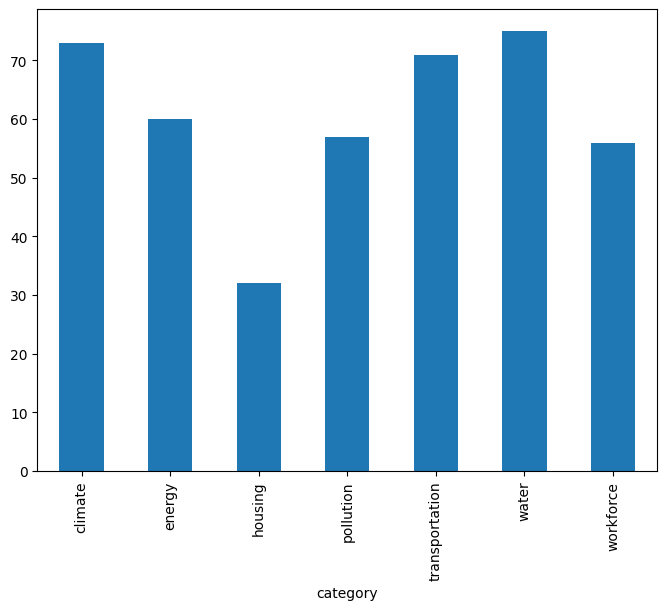

In [26]:
#Explore the cleaned data to see how it's distributed, data is slightly skewed but in our case "it is desirable to have a classifier that gives high prediction accruacy over the majority class, while maintaining reasonable accuracy for the minority classes" so we will leave data as is

fig = plt.figure(figsize=(8,6))
ajcDf.groupby('category').description.count().plot.bar(ylim=0)
plt.show()

In [27]:
#Text Processing - make text readable to algorithm
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(ajcDf.description).toarray()
labels = ajcDf.label
features.shape

(424, 562)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(ajcDf['description'], ajcDf['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
#NBcvs = cross_val_score(clf, features, labels, scoring='accuracy', cv=CV)
#print(NBcvs)


In [29]:
print(clf.predict(count_vect.transform(["The program provides Area Base Development Program grant allocations to ARC states for activities that help bring the 13-state Appalachian region into economic parity with the nation. Each state will operate its own competitive application process. The ARC states are Alabama, Georgia, Kentucky, Maryland, Mississippi, New York, North Carolina, Ohio, Pennsylvania, South Carolina, Tennessee, Virginia, and West Virginia."])))
print(clf.predict(count_vect.transform(["The goal is to assist Tribes and inter-Tribal consortia in developing the capacity to manage their own environmental protection programs and to develop and implement solid and hazardous waste programs in accordance with individual Tribal needs and applicable federal laws and regulations."])))


['workforce']
['pollution']


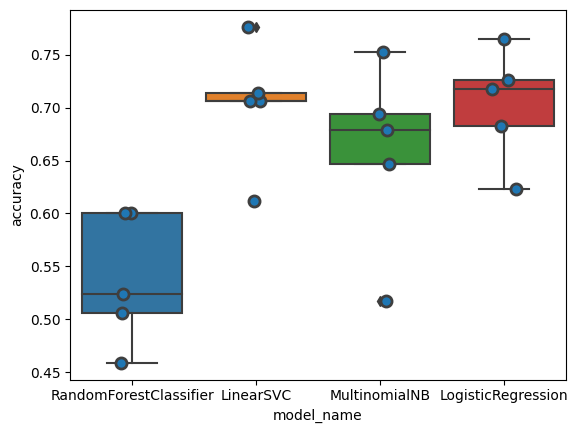

In [30]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.702857
LogisticRegression        0.702885
MultinomialNB             0.658067
RandomForestClassifier    0.537703
Name: accuracy, dtype: float64

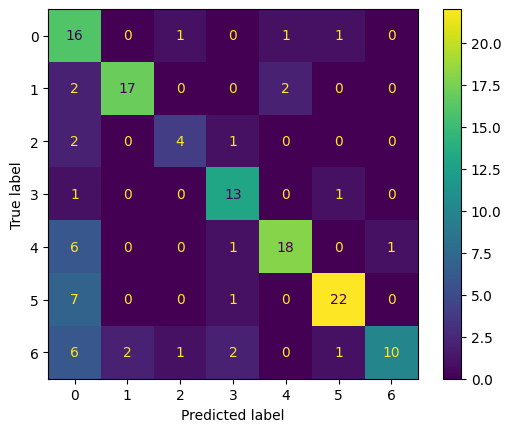

In [31]:
#confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, ajcDf.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

In [34]:
#apply model to new data
X_train, X_test, y_train, y_test = train_test_split(ajcDf['description'], ajcDf['category'], test_size=0.33, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
model = LogisticRegression(random_state=0).fit(X_train_tfidf, y_train)
# Convert a collection of text documents to a vector of term/token counts. 
cntVectData = count_vect.transform(pdfDT['description'])

#RUN Prediction
pdfDT['category'] = model.predict(cntVectData)

pdfDT


webLabel = {'climate':'Climate Change', 'energy':'Clean Energy and Energy Efficiency','housing':'Affordable and sustainable housing','pollution':'remediation and reduction of legacy pollution','transportation':'Clean Transportation','workforce':'Training and workforce development','water':'Critical clean water and wastewater infrastructure'} #create dictionary of agency abbreviates (how to handle subbranch of dod?)
pdfDT['category_label'] = pdfDT['category'].map(webLabel) #map abbreviations to agency names
pdfDT
pdfDT.to_csv('AJCspreadsheet_replica.csv', index=False)

#### Edge Cases (&Upgrades)... [and general todos] to work on: ####

Edge Cases
- More than one page of pdf
- New line break for next word or middle of a word
- Eligibility is listed as varies, broad eligibility, open
- Agricultural eligibility listed elsewhere 
- Look for other words used in absence of a description could be N/A??
- descriptions with > 1 category like transportation workforce is really, transportation and workforce 
- map category to category_label


ToDos
- Make if/elif/else statement for '.indiv' - could possibly do 'not in' statement for if and else and append .indiv but would have to make sure keys are airtight and that all possibilities are explored (cannot do this because it's not true)
- Try to figure out how to do NLP/Topic Classification, which models are best, multiclasses, etc. (*Note you can use the A Just Climate Database for supervised learning)

Updgrades
- How to remove the Setting With Copy Warning from .strip()
- Is it possible to produce more than one category label?

#### Questions??? ####
- Should I get rid of .stateCitiesCounties and just file those under .localGov

#### Notes ####
- Can store large/big data in GridDB it is a open-source, scalable, in memory, NO SQL database which makes it easier to store large amounts of data. 

## Scratch ##

In [39]:
#this box uses PyPDF2 - stopped using PyPDF2 because of weird spaces added 

reader = PdfReader(f)
pdftext = [] #initialize holder for all pdfs
#extract text from all needed pages
#for i in range(15,55): #USE len(reader.pages) as your stop when you are ready to do the whole document
pagecontent = ''.join(reader.pages[15].extract_text().split('\n')) #.join to join all the lists created by split() #use i when doing range, use 15 when testing singular page
pagecontent2 = reader.pages[15].extract_text()

#------------Agency----------------#
pattern = '(?<=Statutory Location: )[\s\w\d\W]+(?=$| Federal Agency: )' #do not include the keyword, include any matches with whitespace or alphanumeric characters with more the one instance, include until new line, EOF, or other keywor
#pattern = '(?<=Funding amount: )[\s\w\d\W]+(?=Period of availability: )'
#pattern2 = r'\bFederal Agency: ' #try this out some more
#keywords = ['Federal Agency: ', 'Funding Amount: ', 'Bureau or Account: ']
#pattern3 = rf"{re.escape(keywords[2])}\s*(.*?)(?=\n|{'|'.join(re.escape(k) for k in keywords if k != keywords[2])})"
agency = re.search(pattern, pagecontent, re.IGNORECASE | re.DOTALL)
#print(agency.group())

#----------Funding Amount-----------#
#pattern = '(?<=\$)\d+' #lookbehind a dollar sign
pattern = '\$[\d.,]+' # \$ regular character $ [\d.,] include digits,dot,comma  + one or more
funding = re.search(pattern, pagecontent) #search text for amount matching the funding pattern
funding_amt = funding.group() #retrieves actual text that matches



#pdftext.append(pagecontent)
#pdftext

In [228]:
A = [1,2,3,4]
shiftA = [A[-1]] + A[:-1]

for keyword in keywords:
    (k for k in keywords if k != keyword) #generator expression if range is large or inifite 
    #for i in list: print(i)

print('second loop')
for keyword in keywords:
    list = [k for k in keywords if k != keyword] #list comprehension for multiple iterations or need for speed
    #for i in list: print(i)


for index, key in enumerate(keywords): 
        key2 = [keywords[index+1] if index < (len(keywords) - 1) else keywords[0]]
        print(key2)

second loop
['Bureau or Account: ']
['Funding amount: ']
['Federal Agency: ']


In [51]:
#for ind in pdfDT.index:
   # print(pdfDT['eligibilityId'].loc[ind], pdfDT['eligibility'].loc[ind])
a = ['a', 'b', 'c']
s = "a123b"
#s = "States, local governments, and nonprofits both with and without 501()(3) status"

tmp = {'a':'Aaaa','b':'Bbbb', 'c':'Cccc'}
tmplist = list(tmp.keys())
matches = {tmp[x] for x in s.lower() if x in tmplist}
print(matches)

#t = "States, local governments, and nonprofits both with and without 501(c)(3) status"
#eligID = {'tribes':'.tribal', 'states':'.stateGov', 'nonprofits':'.ngo', 'local':'.localGov','community':'.communitygroup','university':'.ed', 'education':'.ed','agricultural':'.agricultural'} #what's the difference between stategov, localgov, and statescountiescities, how to code .statesCountiesCities and .indiv 
#pdfDT['eligibilityId'] = pdfDT['eligibility'].map(eligID)
#eligKeys = list(eligID.keys()) # lists out all the keys of the key value pairs

#print(eligKeys)
#matches = {eligID[x] for x in t.lower() if x in eligKeys}
#for index, row in pdfDT.iterrows(): #goes through each row of the dataframe
    #matches = {eligID[x] for x in (row['eligibility']).lower() if x in eligKeys} #s is the string or in this case the eligibility description, this shows the matches b/w the eligibility description and the eligiility keys and spits out a list of corresponding ID values, there is definitely a way to do this regex so I don't have to use .lower() but will figure that out later
    #row['eligibilityId'] = ', '.join(matches)  
#print('Set = '+', '.join(matches))

data = {'Name': ['Ankit', 'Amit',
                 'Aishwarya', 'Priyanka'],
        'Age': [21, 19, 20, 18],
        'Stream': ['Math', 'Commerce',
                   'Arts', 'Biology'],
        'Percentage': [88, 92, 95, 70]}
  
# Convert the dictionary into DataFrame
df = pd.DataFrame(data, columns=['Name', 'Age', 
                                 'Stream', 'Percentage'])
#for index, row in df.iterrows():
   #row["New"] = 'Dr. '+ row["Name"]
   #print(row["Name"], row["Age"], row["New"])

{'Aaaa', 'Bbbb'}


In [ ]:
# 'str' is a built-in function, so use another name instead
string = 'A Test test string from which I want to match, multiple substrings for our States and local governments'
#values = ['test', 'test2', 'Multiple', 'ring', 'match', 'local', 'state']
eligID = {'tribes':'.tribal', 'states':'.stateGov', 'nonprofits':'.ngo', 'local':'.localGov'}
values = list(eligID.keys())

pattern = r'\b({})\b'.format('|'.join(map(re.escape, values)))

# unique matches
matches = set(re.findall(pattern, string.lower(), re.IGNORECASE))
IDlist = {eligID[x] for x in matches}
print(IDlist)